In [66]:

import os

import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt

from storage import upload_to_bucket

from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters
from nrel_uitls import ResStockConfiguration


In [67]:
schema = Schema()

In [68]:

basepath = os.path.dirname(os.getcwd())
filepath = os.path.join(basepath, "NREL", "data", "ResStock", "resstock_filtered.csv")
citypath = os.path.join(os.getcwd(), "data", "city_map.json")
resstock_filtered = pd.read_csv(filepath, index_col=0)
resstock_samples = ResStockConfiguration(resstock_filtered, citypath)
sample_df = resstock_samples.get_template_df()
sample_df.head()
sample_df.RoofRValue.describe()


Dropped 17 samples while cleaning. Now there are 591 samples.


count    591.000000
mean       0.945962
std        1.832182
min        0.037500
25%        0.272143
50%        0.272143
75%        0.272143
max        8.901942
Name: RoofRValue, dtype: float64

In [69]:
sample_df.columns, schema.parameter_names

(Index(['bldg_id', 'archetype', 'vintage', 'climate_zone', 'base_epw',
        'window_type', 'wwr', 'heating_setpoint', 'cooling_setpoint',
        'Infiltration', 'dhw_flow', 'PeopleDensity', 'LightingPowerDensity',
        'EquipmentPowerDensity', 'FacadeMass', 'FacadeRValue', 'RoofRValue',
        'PartitionRValue', 'SlabRValue', 'has_electric_heating', 'heating_cop',
        'has_cooling', 'cooling_cop'],
       dtype='object'),
 ['batch_id',
  'variation_id',
  'program_type',
  'vintage',
  'climate_zone',
  'base_epw',
  'width',
  'height',
  'facade_2_footprint',
  'perim_2_footprint',
  'roof_2_footprint',
  'footprint_2_ground',
  'wwr',
  'orientation',
  'HeatingSetpoint',
  'CoolingSetpoint',
  'LightingPowerDensity',
  'EquipmentPowerDensity',
  'PeopleDensity',
  'Infiltration',
  'FacadeMass',
  'RoofMass',
  'FacadeRValue',
  'RoofRValue',
  'SlabRValue',
  'WindowSettings',
  'schedules_seed',
  'schedules'])

In [1]:
start_ix = 0
batches_to_gen = 591
batches = []
for batch_id in range(start_ix, start_ix+batches_to_gen):
    base = sample_df.iloc[batch_id]
    storage_batch = schema.generate_empty_storage_batch(1)
    print(base.base_epw)
    print(base.RoofRValue)
    print(base.FacadeMass)
    
    # Set Constants
    schema.update_storage_batch(storage_batch,parameter="batch_id",value=batch_id)
    schema.update_storage_batch(storage_batch,parameter="base_epw",value=base.base_epw)
    schema.update_storage_batch(storage_batch,parameter="climate_zone",value=base.climate_zone)
    schema.update_storage_batch(storage_batch,parameter="program_type",value=base.archetype)
    schema.update_storage_batch(storage_batch,parameter="vintage",value=base.vintage)
    
    # Set Defaults
    schema.update_storage_batch(storage_batch, parameter="wwr", value=base.wwr)
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=base.heating_setpoint)
    schema.update_storage_batch(storage_batch, parameter="CoolingSetpoint", value=base.cooling_setpoint)
    schema.update_storage_batch(storage_batch, parameter="Infiltration", value=base.Infiltration)
    schema.update_storage_batch(storage_batch, parameter="EquipmentPowerDensity", value=base.EquipmentPowerDensity)
    schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=base.LightingPowerDensity)
    schema.update_storage_batch(storage_batch, parameter="PeopleDensity", value=base.PeopleDensity)
    schema.update_storage_batch(storage_batch, parameter="FacadeMass", value=base.FacadeMass)
    schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=base.FacadeRValue)
    schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=base.RoofRValue)
    schema.update_storage_batch(storage_batch, parameter="SlabRValue", value=base.SlabRValue)

    schema.update_storage_batch(storage_batch, parameter="WindowSettings", value=np.array([0.7,0.5,0.7])) 

    # TODO: roofmass
    # TODO: windows
    # TODO: add summed output of product of schedules with loads
    # TODO: Internal mass?

    # Generate Orientations
    storage_batch = storage_batch.repeat(4,axis=0)
    orientations = np.arange(4).reshape(-1,1)
    schema.update_storage_batch(storage_batch, parameter="orientation", value=orientations)

    # geneate geometric variations
    geo_var_ct = 5
    storage_batch = storage_batch.repeat(geo_var_ct,axis=0)
    for j,parameter in enumerate(schema.parameters):
        if isinstance(parameter, ShoeboxGeometryParameter):
            name = parameter.name
            mean = parameter.mean
            std = parameter.std
            shape = parameter.shape_storage
            values = np.random.normal(loc=mean, scale=std, size=(storage_batch.shape[0], *shape))
            schema.update_storage_batch(storage_batch, parameter=name, value=values)
    
    """Generate Schedules"""
    sched_var_ct = 10
    storage_batch = storage_batch.repeat(sched_var_ct, axis=0)
    for minibatch_ix in range(0,storage_batch.shape[0],sched_var_ct):
        vec_base_ix = minibatch_ix
        for sched_ix in range(sched_var_ct):
            vec_ix = vec_base_ix + sched_ix
            schedules = schema["schedules"].extract_storage_values(storage_batch[vec_ix])
            if sched_ix == 0:
                # use default sched
                pass
            elif sched_ix == 1:
                # all on
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["on/off"]] = 1
            elif sched_ix == 2:
                # all off
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["on/off"]] = -1
            elif sched_ix == 3:
                # Daily random
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # 1 days worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 4:
                # Daily random
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 2
            elif sched_ix == 5:
                # Daily rando
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = (j+1)*2 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/(j+1)*2*7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 2
            # elif sched_ix == 4:
            #     # Weekly random
            #     for j in range(3):
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 4 # 4hr per sample
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/4*7 # 1 week worth of samples
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            # elif sched_ix == 5:
            #     # Weekly random
            #     for j in range(3):
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 2 # 2hr per sample
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/2*7 # 2 worth of samples
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 6:
                # Inverted
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["invert"]] = 1
            elif sched_ix == 7:
                # Noise
                for j in range(3):
                    # schedules[j, SchedulesParameters.op_indices["noise"]] = 0.2
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 24 # 1day per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 8:
                # work week
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["pulse_period"]] = 24*7 # 1 week
                    schedules[j, SchedulesParameters.op_indices["pulse_width"]] = 24*5 # 5 days
            elif sched_ix == 9:
                # phasing
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["pulse_period"]] = 12 # 1 week
                    schedules[j, SchedulesParameters.op_indices["pulse_width"]] = 4 # 5 days
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = int(np.random.random()*8+2) # 1hr per sample
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 12
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 21 # 21 hours per sample
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 2*24*7 / 21 # 2 week worth of samples
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0


    """Finalize Batch"""
    storage_batch = storage_batch.repeat(5, axis=0)
    n = storage_batch.shape[0]
    # TODO:? Appy specific upgrades? or just use perturbations
    
    """Pertub Geometry"""
    for j,parameter in enumerate(schema.parameters):
        if isinstance(parameter, ShoeboxGeometryParameter):
            name = parameter.name
            mean = parameter.mean
            std = parameter.std
            shape = parameter.shape_storage
            values = schema[name].extract_storage_values_batch(storage_batch)
            mods = np.random.normal(loc=0, scale=std/4, size=(n, *shape))
            values = values + mods
            schema.update_storage_batch(storage_batch, parameter=name, value=values)

    """Perturb Building Parameters"""

    heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(storage_batch)
    shape = schema["HeatingSetpoint"].shape_storage
    heating_setpoints = heating_setpoints + np.random.normal(loc=0, scale=1, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=heating_setpoints)

    shape = schema["CoolingSetpoint"].shape_storage
    cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(storage_batch)
    cooling_setpoints = cooling_setpoints + np.random.normal(loc=0, scale=1, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="CoolingSetpoint", value=cooling_setpoints)

    shape = schema["Infiltration"].shape_storage
    infiltration = schema["Infiltration"].extract_storage_values_batch(storage_batch)
    infiltration = infiltration + np.random.normal(loc=-0.2, scale=0.2, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="Infiltration", value=infiltration)

    shape = schema["EquipmentPowerDensity"].shape_storage
    epd = schema["EquipmentPowerDensity"].extract_storage_values_batch(storage_batch)
    epd = epd + np.random.normal(loc=0, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="EquipmentPowerDensity", value=epd)

    shape = schema["LightingPowerDensity"].shape_storage
    lpd = schema["LightingPowerDensity"].extract_storage_values_batch(storage_batch)
    lpd = lpd + np.random.normal(loc=1, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=lpd)

    shape = schema["PeopleDensity"].shape_storage
    ppd = schema["PeopleDensity"].extract_storage_values_batch(storage_batch)
    ppd = ppd + np.random.normal(loc=0, scale=0.005, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="PeopleDensity", value=ppd)

    shape = schema["FacadeMass"].shape_storage
    facade_mass = schema["FacadeMass"].extract_storage_values_batch(storage_batch)
    facade_mass = facade_mass + np.random.normal(loc=0 if base.FacadeMass > 50000 else 50000, scale=25000, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="FacadeMass", value=facade_mass)

    shape = schema["RoofMass"].shape_storage
    roof_mass= np.random.normal(loc=schema["RoofMass"].mean, scale=schema["RoofMass"].std, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="RoofMass", value=roof_mass)

    shape = schema["FacadeRValue"].shape_storage
    facade_rv = schema["FacadeRValue"].extract_storage_values_batch(storage_batch)
    facade_rv = facade_rv + np.random.normal(loc=1.5, scale=0.75, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=facade_rv)

    shape = schema["RoofRValue"].shape_storage
    roof_rv = schema["RoofRValue"].extract_storage_values_batch(storage_batch)
    roof_rv = roof_rv + np.random.normal(loc=1.5, scale=0.75, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=roof_rv)

    shape = schema["SlabRValue"].shape_storage
    slab_rv = schema["SlabRValue"].extract_storage_values_batch(storage_batch)
    slab_rv = slab_rv + np.random.normal(loc=0.5, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="SlabRValue", value=slab_rv)

    # Windows
    window_vals = schema["WindowSettings"].extract_storage_values_batch(storage_batch)
    window_vals[:,0] = np.random.normal(loc=3.5, scale=1.5, size=(n,))
    schema.update_storage_batch(storage_batch, parameter="WindowSettings", value=window_vals)

    # Protect Setpoints
    heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(storage_batch)
    cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(storage_batch)
    heating_setpoints = np.where(heating_setpoints > cooling_setpoints, cooling_setpoints-2, heating_setpoints)
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=heating_setpoints)

    # Set Variation ID
    variation_ids = np.arange(n)
    schema.update_storage_batch(storage_batch,parameter="variation_id",value=variation_ids)
    schema.update_storage_batch(storage_batch,parameter="schedules_seed",value=(np.random.random(1))*n*variation_ids)

    batches.append(storage_batch)

    # Write to an HDF5 file
    slug = f"batch_{batch_id:05d}.hdf5"
    outfile = f"./data/hdf5/{slug}"
    with h5py.File(outfile,"w") as f:
        f.create_dataset(name="storage_vectors", shape=storage_batch.shape, dtype=storage_batch.dtype, data=storage_batch)

    # upload to cloud bucket for easy backup
    destination = f"final_batches/{slug}"
    upload_to_bucket(destination, outfile)
all_batches = np.vstack(batches)

NameError: name 'sample_df' is not defined

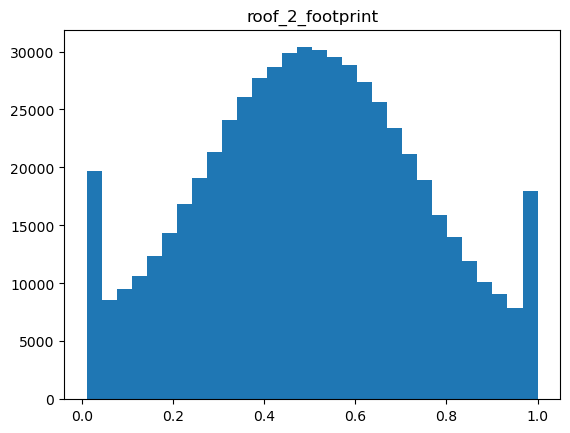

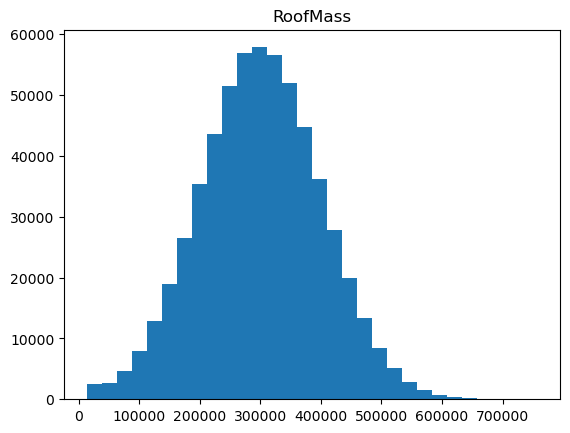

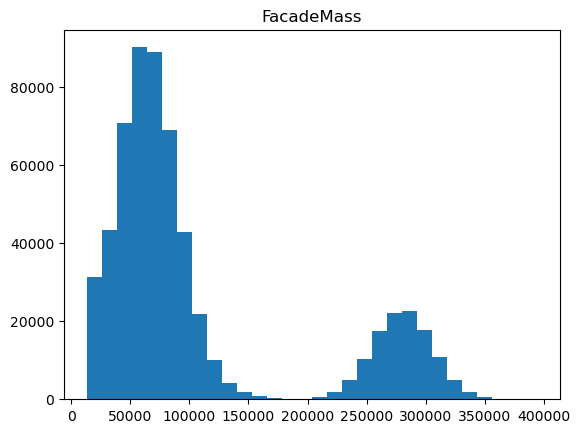

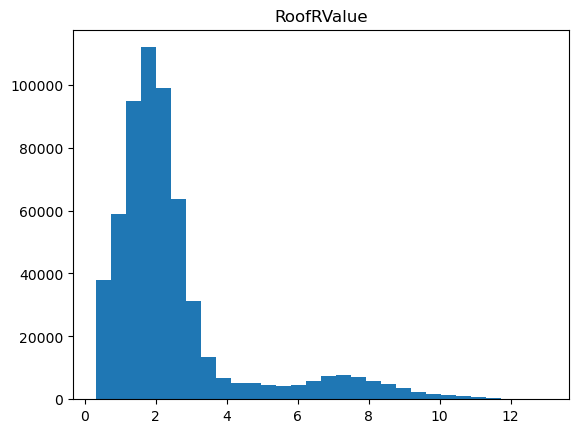

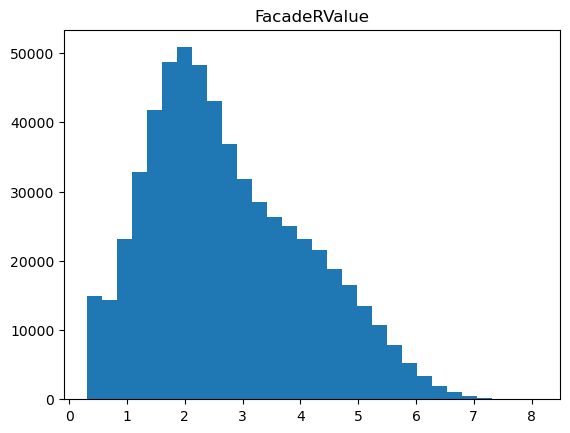

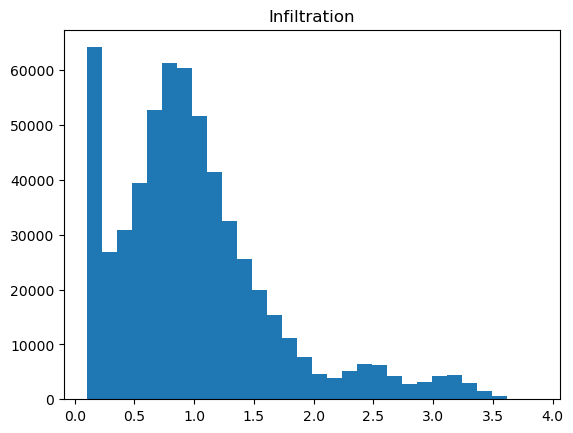

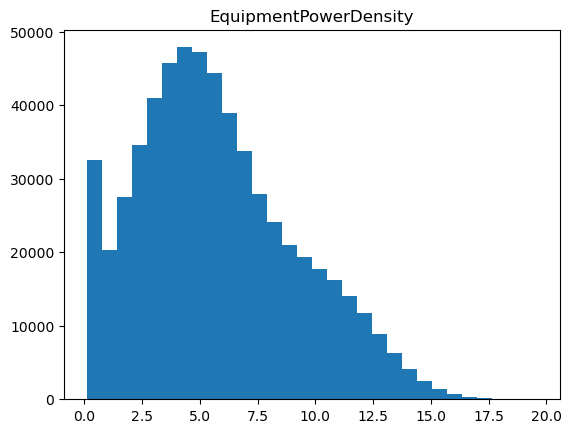

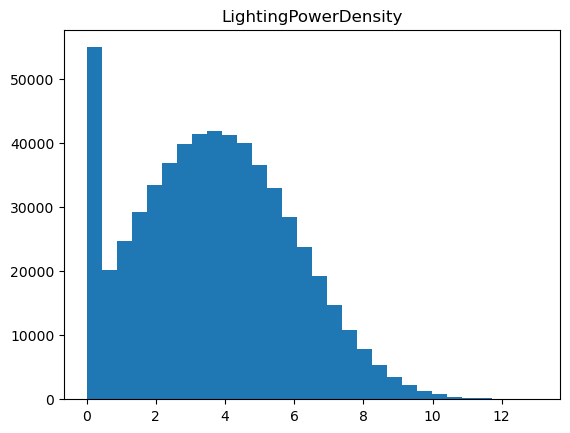

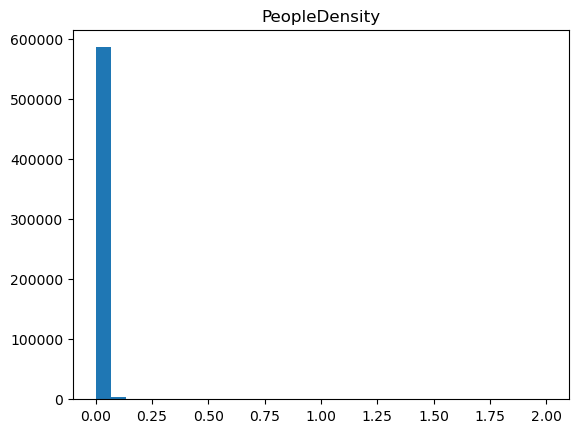

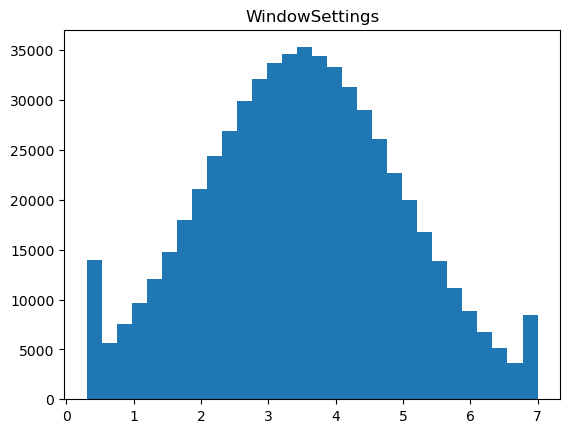

In [71]:
for param in ["roof_2_footprint","RoofMass", "FacadeMass", "RoofRValue", "FacadeRValue", "Infiltration", "EquipmentPowerDensity", "LightingPowerDensity", "PeopleDensity", "WindowSettings"]:
    plt.figure()
    vals = schema[param].extract_storage_values_batch(all_batches)
    plt.title(param)
    if param == "WindowSettings":
        vals = vals[:,0]
    hist = plt.hist(vals.flatten(), bins=30)